In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Activation, BatchNormalization, Add,GlobalMaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
image=ImageDataGenerator(rescale = 1.0/255.0,validation_split=.1)
train=image.flow_from_directory("/content/drive/MyDrive/Datasets",target_size=(224,224),class_mode='sparse',batch_size=10,subset='training',shuffle=True,seed=123)
testing=image.flow_from_directory("/content/drive/MyDrive/Datasets",target_size=(224,224),class_mode='sparse',batch_size=1,subset='validation')

Found 1711 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [ ]:
train.class_indices

{'Defective': 0, 'Non_Defective': 1}

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Set up validation
val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')


In [ ]:
import numpy as np

def relu6(x):
    return np.clip(x, 0, 6)


In [ ]:
#Function for the inverted residual block
def inverted_residual_block(inputs, filters, expansion_factor, stride):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
   
    input_num_filters =  K.int_shape(inputs)[channel_axis]
    inner_num_filters = input_num_filters * expansion_factor

    # Apply pointwise convolution with expansion
    x = layers.Conv2D(inner_num_filters, (1, 1), padding='same',kernel_regularizer=L2(0.01), use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu6')(x)

    # Apply depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=5, strides=stride, padding='same',kernel_regularizer=L2(0.01), use_bias=False)(x)    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu6')(x)

    # Apply pointwise convolution to project back to the original number of filters(compressing)
    x = layers.Conv2D(filters, (1, 1), padding='same',kernel_regularizer=L2(0.01), use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Apply skip connection for same spatial dimension of tensors(identity skip connction)
    if (stride == 1) and (input_num_filters == filters):
        x = layers.Add()([x, inputs])
        return x
    
    # Apply skip connection using a 1x1 convolution
    # Apply skip connection if the number of filters or resolution changes(convolutional skip connection)
    shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    return Add()([x, shortcut])

In [ ]:
#Base model building
def build_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Conv2D(16, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
   

    
    # Inverted residual blocks
    x = inverted_residual_block(x, expansion_factor=1, filters=16, stride=(1, 1))

    x = inverted_residual_block(x, expansion_factor=6, filters=24, stride=(2, 2))
    x = inverted_residual_block(x, expansion_factor=6, filters=24, stride=(1, 1))

    x = inverted_residual_block(x, expansion_factor=6, filters=32, stride=(2, 2))
    x = inverted_residual_block(x, expansion_factor=6, filters=32, stride=(1, 1))
   
    x = inverted_residual_block(x, expansion_factor=6, filters=64, stride=(2, 2))
    x = inverted_residual_block(x, expansion_factor=6, filters=64, stride=(1, 1))
   
    x = inverted_residual_block(x, expansion_factor=6, filters=96, stride=(2, 2))
    x = inverted_residual_block(x, expansion_factor=6, filters=96, stride=(1, 1))
    x = inverted_residual_block(x, expansion_factor=6, filters=96, stride=(1, 1))
    x = Dropout(0.1)(x)
    x = inverted_residual_block(x, expansion_factor=6, filters=160, stride=(2, 2))
    x = inverted_residual_block(x, expansion_factor=6, filters=160, stride=(1, 1))

    
    # Exit block
    x = Conv2D(320, kernel_size=3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    return model

In [ ]:
model1=build_cnn_model((224,224,3),2)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', val_loss, val_accuracy])


In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model1.fit(train, validation_data=testing, epochs=20, callbacks=[early_stop])


Epoch 1/20
172/172 [==============================] - 311s 1s/step - loss: 27.1481 - accuracy: 0.5944 - val_loss: 26.5852 - val_accuracy: 0.5000 - val_val_loss: 0.7018 - val_val_accuracy: 0.5000
Epoch 2/20
172/172 [==============================] - 85s 496ms/step - loss: 26.2238 - accuracy: 0.7195 - val_loss: 26.1925 - val_accuracy: 0.5000 - val_val_loss: 0.8604 - val_val_accuracy: 0.5000
Epoch 3/20
172/172 [==============================] - 84s 491ms/step - loss: 25.5092 - accuracy: 0.8077 - val_loss: 26.2120 - val_accuracy: 0.5000 - val_val_loss: 1.4602 - val_val_accuracy: 0.5000
Epoch 4/20
172/172 [==============================] - 87s 508ms/step - loss: 24.7906 - accuracy: 0.8586 - val_loss: 26.6849 - val_accuracy: 0.5053 - val_val_loss: 2.5325 - val_val_accuracy: 0.5053
Epoch 5/20
172/172 [==============================] - 84s 487ms/step - loss: 24.0783 - accuracy: 0.9141 - val_loss: 36.5091 - val_accuracy: 0.5000 - val_val_loss: 12.9858 - val_val_accuracy: 0.5000
Epoch 6/20
172/1

In [ ]:
y_pred=model1.predict(testing)

190/190 [==============================] - 9s 46ms/step


In [ ]:
y_true = testing.classes

from sklearn.metrics import confusion_matrix
import numpy as np

y_pred=np.argmax(y_pred,axis=1)
y_pred

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
cm = confusion_matrix(y_true,y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.47
Precision: 0.48
Recall: 0.69


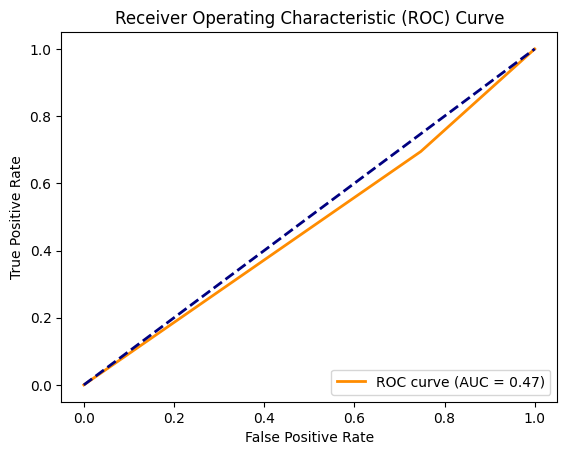

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# assume y_true and y_score are the true labels and predicted probabilities, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np

# y_pred contains predicted probabilities from the sigmoid function
y_pred = np.array(y_pred)

# Define the threshold
threshold = 0.5

# Convert predicted probabilities to integer values
y_pred_int = (y_pred > threshold).astype(int)
y_pred_int=np.array(y_pred_int)

# Print the integer values
print(y_pred_int)


[1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1
 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0
 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1]


In [ ]:
model1.evaluate(testing)

190/190 [==============================] - 8s 43ms/step - loss: 15.4004 - accuracy: 0.6842 - val_loss: 1.4694 - val_accuracy: 0.6842


[15.40036392211914, 0.6842105388641357, 1.469422698020935, 0.6842105388641357]

In [ ]:
from PIL import Image
import numpy as np

# Load the image
img = Image.open("/content/drive/MyDrive/CNNmod1/train/ok_front/cast_ok_0_2098.jpeg")

# Resize the image
img = img.resize((224, 224))

# Convert the image to a NumPy array
img_array = np.array(img)

# Preprocess the image (e.g. normalize pixel values)
img_array = img_array / 255.0

# Add batch dimension to the image array (required for input to many models)
img_array = np.expand_dims(img_array, axis=0)

# Pass the image to the model for prediction
y_pred = model1.predict(img_array)

# Convert predicted probabilities to integer values
#y_pred_int = (y_pred > 0.5).astype(int)

# Print the predicted class label
print(y_pred)


FileNotFoundError: ignored

In [ ]:
y_pred=np.argmax(y_pred,axis=1)
y_pred

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

# Load the images from the directory
predict_data = datagen.flow_from_directory(
                                            directory='path/to/directory',
                                            target_size=(224, 224),
                                            class_mode=None,
                                            shuffle=False)